In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import tqdm

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from doom_src import utilities
from collections import deque
from time import time
from vizdoom import *

In [2]:
policy_net = tf.keras.models.load_model('saved_models/DQN_mk2_policy.h5')

In [3]:
policy_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_31 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 6, 6, 64)          65600     
_________________________________________________________________
batch_normalization_32 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)              0         
__________

In [4]:
config = utilities.get_config('configs/config.json')

In [5]:
game, actions = utilities.create_environment(config, visible=True)

In [15]:
def predict_action(policy_network, epsilon, state, actions):
    """
    Implements the epsilon-greedy strategy
    """
    
    if np.random.rand(1) < epsilon:
        max_Q = np.random.randint(len(actions))
    
    else:
        # print(state.shape)
        q = policy_network.predict(state.reshape([1,] + list(state.shape)))
        max_Q = np.argmax(q)
        # print(q, max_Q)
    
    action = actions[max_Q]
        
    return action, max_Q 

In [18]:
def evaluate_model(policy_net, game, actions, n_episodes):
    stack_size      = config['stack_size']
    frame_size      = config['frame_size']
    skip_rate       = config['skip_rate']
    
    episode_rewards = []
    eps = 0.0
    
    # Inititalize the stack of frames
    stacked_frames = deque(
        [np.zeros((frame_size, frame_size), dtype=np.int) for i in range(stack_size)], 
        maxlen=stack_size
    ) 
    
    for i in tqdm.tqdm(range(n_episodes)):
        episode_reward = 0.0
        
        game.new_episode()
        done = game.is_episode_finished()
        
        # Initial state
        frame = game.get_state().screen_buffer
        state = utilities.stack_frames(
            stacked_frames, frame, True, stack_size, frame_size
        )
        
    
        while not done:
            # Action selection phase
            action, action_index = predict_action(policy_net, eps, state, actions)

            reward = game.make_action(action, skip_rate)
            done = game.is_episode_finished()

            # Next state
            if done: # Dead
                frame = np.zeros(frame.shape)
            
            else:
                frame = game.get_state().screen_buffer
            
            state = utilities.stack_frames(
                stacked_frames, frame, False, stack_size, frame_size
            )
            
            episode_reward += reward
        
        episode_rewards.append(episode_reward)
    
    return episode_rewards
            

In [19]:
episode_rewards = evaluate_model(policy_net, game, actions, 1000)

100%|██████████| 1000/1000 [12:32<00:00,  1.35it/s]


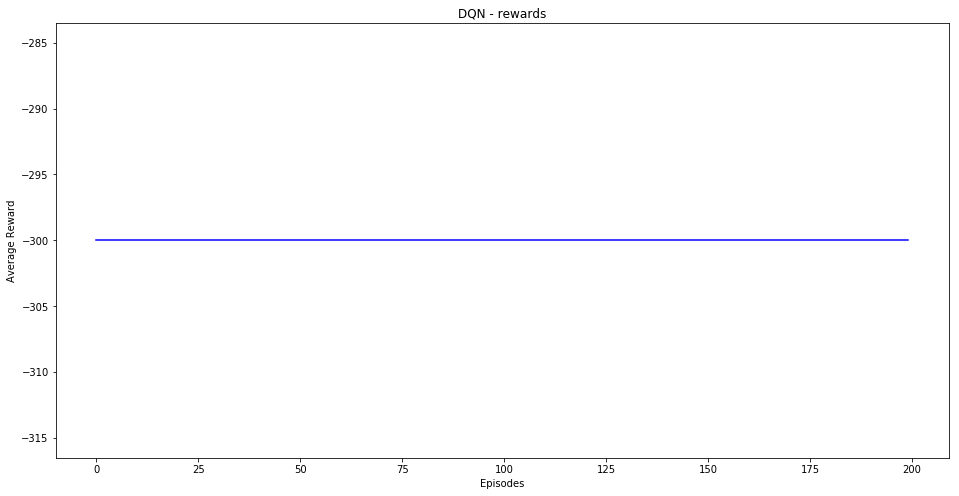

In [20]:
utilities.plot_reward_curve(episode_rewards, "DQN - rewards", 5)